In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

from scipy import stats
from pymer4.models import Lmer, Lm
import statsmodels  as sm

from pymer4.io import save_model, load_model

/tmp/ipykernel_14203/1793616659.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Loading and preparing data

In [57]:
# Loading dataframe
# Loading dataframe
df = pd.read_csv("data/exp2_implicit.csv")
df = df[df["invalid_catch"]==0] # Eliminates entire auditory block in which participant did not detect any visual catch (as it could mean they weren't even looking at the screen)

In [58]:
dat = df.groupby("id", as_index=0)["correct"].mean() 
out = list(dat[dat.correct < .6]["id"]) # removing participants with less than 60% accuracy
df = df[~(df.id.isin(out))]
df.reset_index(drop="True", inplace=True)

df["id"].nunique()

57

In [60]:
pg.pairwise_tests(data = df, dv="correct", within=["ign_pred"], subject="id", effsize="cohen")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,ign_pred,EXP,VP,True,True,4.829494,56.0,two-sided,0.000011,1698.334,0.353168


In [59]:
df.groupby("modality")["id"].nunique()

modality
auditory    26
visual      31
Name: id, dtype: int64

In [8]:
# Defining factors for pymer4 lmm function
pred = {"pred" : ["EXP", "VP"]}
ign_pred = {"ign_pred" : ["EXP", "VP"]}
relevant_expected = {"relevant_expected" : ["0", "1"]}
irrelevant_expected = {"irrelevant_expected" : ["0", "1"]}
att_learned = {"att_learned" : ["0", "1"]}
ign_learned = {"ign_learned" : ["0", "1"]}
modality = {"modality": ["auditory", "visual"]}

In [10]:
# Transforming numeric factors to string for pymer
df["relevant_expected"] = df["relevant_expected"].astype("str")
df["irrelevant_expected"] = df["irrelevant_expected"].astype("str")

df["att_learned"] = df["att_learned"].astype("str")
df["ign_learned"] = df["ign_learned"].astype("str")

# Functions

Here I define functions to use for several analyses

In [12]:
def reportAIC(models):
    modeln = 0
    for model in models:
        print(f"Model {modeln}: {model.formula}   AIC: {model.AIC} ||  BIC: {model.BIC}")
        modeln += 1

In [13]:
# Alexis barplot function
def barsplot(data, dx, dy, hue, col, row, pal, paldot, size, yaxis, axislabels, sizepoint, dodge, lines = False):
    sns.set(font_scale = 1.5, style = "ticks")
    ort = "v"; pal = pal; sigma = .5
    g = sns.FacetGrid(data ,  row = row, col = col, height= size["height"], aspect=size["aspect"], margin_titles=True) # col=“nrep”,
    if sizepoint == None:
        sizepoint = 6
    if yaxis != None:
        g.set(ylim = yaxis["ylim"], yticks=yaxis["yticks"])
    if lines == True:
        g.map_dataframe(sns.lineplot, data= data, x= dx, y= dy, units= "id" , estimator=None, linewidth = 0.3, color = 'grey')
    g.map_dataframe(sns.stripplot, x = dx, y = dy, palette = paldot, hue=hue, size = sizepoint, edgecolor = "black",
                    linewidth = 0.6, jitter = 0.05, orient = ort,alpha = 0.5, dodge=dodge)
    g.map_dataframe(sns.barplot, x = dx, y = dy, palette = pal, hue=hue,  linewidth = 0.6, orient = ort, dodge=dodge)
    #g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = “area”, width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
    #g.add_legend(fontsize=axislabels["fontsize"]*0.75)
    sns.despine(offset = .5,  trim=True)
    g.set(xticklabels = axislabels["xticks"])
    g.set_xticklabels(fontsize=axislabels["fontsize"]*0.8)
    if axislabels["rotation"] != None:
        g.set_xticklabels(rotation = axislabels["rotation"])
    # Set x-axis and y-axis labels
    g.set_axis_labels( axislabels["xlabel"] , axislabels["ylabel"], fontsize = axislabels["fontsize"] )
    g.set_titles(col_template = '{col_name}')
    #g.tight_layout()
    return g

In [14]:
def dprime(df, signal, sval, resp): 
    # This function takes in a dataframe, the signal variable name, the signal present value, and the "yes" responses value
    # Outputs a dataframe with cols: hit (rate), miss, false alarm, correct rejection, dprime, criterion
    n = len(df)
    d = {}
    signal = df[signal] == sval
    response = df["resp"] == resp
    
    hits =response[signal].mean()
    if hits == 1: 
        hit = (n-0.5)/n 
    elif hits == 0: 
        hit = 0.5/n
    else: 
        hit = hits; 
    d["hit"] = hit
    
    miss = ~response[signal] ; d["miss"] = miss.mean()
    
    fas = response[~signal].mean()
    if fas == 1: 
        fa = (n-0.5)/n 
    elif fas == 0: 
        fa = 0.5/n
    else: fa = fas 
    d["fa"] = fa
    
    cr = ~response[~signal] ; d["cr"] = cr.mean()
    
    d["dprime"] = stats.norm.ppf(hit) - stats.norm.ppf(fa)
    d["c"] = -(stats.norm.ppf(hit) + stats.norm.ppf(fa))/2.0

    return pd.Series(d, index = ["hit", "miss", "fa", "cr", "dprime", "c"])

# **Question 1**: do relevant and irrelevant perceptual predictions modulate performance (accuracy and RTs)?

## Relevant modality predictions

### Accuracy

In [61]:
df.groupby(["relevant_expected"], as_index=0)["correct"].mean()


,relevant_expected,correct
0,0,0.778298
1,1,0.830982


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,modality,0.463691,1,55,0.463691,48.942199,3.831296e-09,0.470860,NaN
1,relevant_expected,0.066971,1,55,0.066971,43.730444,1.622059e-08,0.442928,1.0
2,Interaction,0.000324,1,55,0.000324,0.211345,6.475271e-01,0.003828,NaN


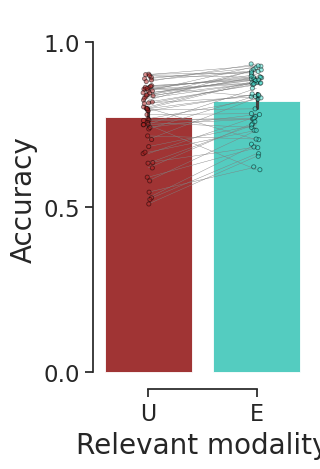

In [45]:
dat = df.groupby(["id", "modality", "relevant_expected"], as_index=0)["correct"].mean()
sizeplot = {}; sizeplot["height"] = 5; sizeplot["aspect"] = .7
axislabels = {}; axislabels["xlabel"] = 'Relevant modality'; axislabels["ylabel"]= "Accuracy"; axislabels["fontsize"]= 20; axislabels["xticks"] = ["U", "E"]; axislabels["rotation"] = 0
yaxis = {}; yaxis["yticks"]=[0, .5, 1]; yaxis["ylim"] = [-0.05,1.1]
dx = "relevant_expected"; dy = "correct"; hue = "relevant_expected";  row = None; col = None #"modality"
pal = ["firebrick", "turquoise"]
barsplot(dat, dx, dy, dx, col, row, pal, pal, sizeplot, yaxis, axislabels, sizepoint = 3, dodge = False, lines = True)
dat.groupby("relevant_expected")["correct"].mean()
pg.mixed_anova(dv="correct", within= "relevant_expected", between = "modality", subject='id', correction='auto', effsize = "np2", data=dat)

#plt.savefig("figures/exp2/att_accuracy.png", dpi=500)

### Reaction times

In [17]:
df.groupby([ "relevant_expected"], as_index=0)["RT"].mean()

,relevant_expected,RT
0,0,0.562529
1,1,0.537486


## Irrelevant modality predictions

### Accuracy

In [19]:
df.groupby([ "irrelevant_expected"], as_index=0)["correct"].mean()

,irrelevant_expected,correct
0,0,0.789389
1,1,0.827274


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,irrelevant_expected,1,56,23.32401,0.000011,0.294035,1.0


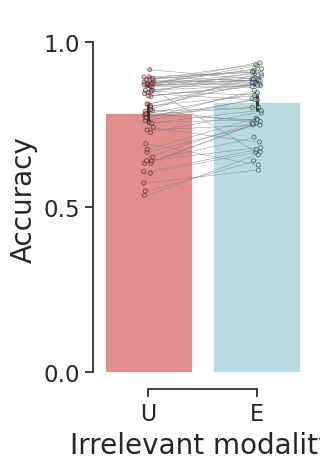

In [20]:
dat = df.groupby(["id", "modality", "irrelevant_expected"], as_index=0)["correct"].mean()
sizeplot = {}; sizeplot["height"] = 5; sizeplot["aspect"] = .7
axislabels = {}; axislabels["xlabel"] = 'Irrelevant modality'; axislabels["ylabel"]= "Accuracy"; axislabels["fontsize"]= 20; axislabels["xticks"] = ["U", "E"]; axislabels["rotation"] = 0
yaxis = {}; yaxis["yticks"]=[0, .5, 1]; yaxis["ylim"] = [-0.05,1.1]
dx = "irrelevant_expected"; dy = "correct"; hue = "irrelevant_expected";  row = None; col = None
pal = ["lightcoral", "powderblue"]
barsplot(dat, dx, dy, dx, col, None, pal, pal, sizeplot, yaxis, axislabels, sizepoint = 3, dodge = False, lines = True)
pg.rm_anova(dv="correct", within= ["irrelevant_expected"], subject='id', correction='auto', effsize = "np2", data=dat)

#plt.savefig("figures/exp2/unatt_accuracy.png", dpi=500)

### Reaction times

In [21]:
df.groupby(["irrelevant_expected"], as_index=0)["RT"].mean()

,irrelevant_expected,RT
0,0,0.554014
1,1,0.540330


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,irrelevant_expected,1,56,6.855379,0.011347,0.109066,1.0


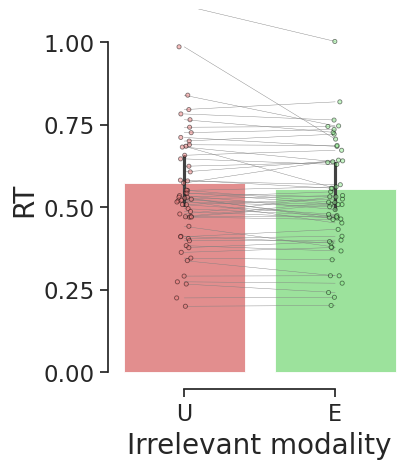

In [22]:
dat = df.groupby(["id", "irrelevant_expected"], as_index=0)["RT"].mean()
sizeplot = {}; sizeplot["height"] = 5; sizeplot["aspect"] = 0.9
axislabels = {}; axislabels["xlabel"] = 'Irrelevant modality'; axislabels["ylabel"]= "RT"; axislabels["fontsize"]= 20; axislabels["xticks"] = ["U", "E"]; axislabels["rotation"] = 0
yaxis = {}; yaxis["yticks"]=[0, .25, .5, .75, 1]; yaxis["ylim"] = [-0.05,1.1]
dx = "irrelevant_expected"; dy = "RT"; hue = "irrelevant_expected";  row = None; col = None
pal = ["lightcoral", "lightgreen"]
barsplot(dat, dx, dy, dx, col, None, pal, pal, sizeplot, yaxis, axislabels, sizepoint = 3, dodge = False, lines = True)
pg.rm_anova(dv="RT", within= "irrelevant_expected", subject='id', correction='auto', effsize = "np2", data=dat)


# Question 2: how does this happen? Changes on sensitivity and bias

## Relevant

In [46]:
relevant_change = Lmer("response ~ change * relevant_expected + (1 + change | id)", data = df, family="binomial") 
relevant_change.fit(factors={**relevant_expected, **modality})

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~change*relevant_expected+(1+change|id)

Family: binomial	 Inference: parametric

Number of observations: 32421	 Groups: {'id': 57.0}

Log-likelihood: -13846.913 	 AIC: 27707.825

Random effects:

           Name    Var    Std
id  (Intercept)  0.500  0.707
id       change  4.135  2.033

            IV1     IV2   Corr
id  (Intercept)  change -0.792

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.753,-1.957,-1.549,0.104,0.173,0.141,0.213,0.148,0.124,0.175,-16.825,0.0,***
change,3.557,3.008,4.106,0.280,35.055,20.238,60.723,0.972,0.953,0.984,12.690,0.0,***
relevant_expected1,-0.433,-0.530,-0.336,0.049,0.649,0.589,0.714,0.393,0.371,0.417,-8.779,0.0,***
change:relevant_expected1,0.514,0.361,0.668,0.078,1.673,1.435,1.950,0.626,0.589,0.661,6.571,0.0,***


In [36]:
# # Load models
# relevant_change1 = load_model("models/exp2_combined/relevantchange1.joblib") # response ~ change * relevant_expected + (1|id)
# relevant_change2 = load_model("models/exp2_combined/relevantchange2.joblib") # response ~ change * relevant_expected + (1 + change|id)
# relevant_change3 = load_model("models/exp2_combined/relevantchange3.joblib") # response ~ change * relevant_expected + modality + (1|id)
# relevant_change4 = load_model("models/exp2_combined/relevantchange4.joblib") # response ~ change * relevant_expected + modality + (1 + change|id)
# relevant_change5 = load_model("models/exp2_combined/relevantchange5.joblib") # response ~ change * relevant_expected * modality + (1 + change|id)
# # relevant_change6 = load_model("models/exp1/exp1_relevantchange6.joblib") # response ~ change * relevant_expected + modality + (1 + change + modality|id)
# # relevant_change7 = load_model("models/exp1/exp1_relevantchange7.joblib") # response ~ change * relevant_expected * modality + (1 + change + modality|id)
# # relevant_change8 = load_model("models/exp1/exp1_relevantchange8.joblib") # response ~ change * relevant_expected * modality + (1 + change * modality|id)  

# # Compare models
# reportAIC([relevant_change1, relevant_change2, relevant_change3, relevant_change4, relevant_change5])

# # Best model that converges is model 5 

Model 0: response~change*relevant_expected+(1|id)   AIC: 29951.45781979192 ||  BIC: 29993.38198414682
Model 1: response~change*relevant_expected+(1+change|id)   AIC: 27632.367722145147 ||  BIC: 27691.061552242005
Model 2: response~change*relevant_expected+modality+(1|id)   AIC: 29953.171771597812 ||  BIC: 30003.48076882369
Model 3: response~change*relevant_expected+modality+(1+change|id)   AIC: 27620.383670596933 ||  BIC: 27687.46233356477
Model 4: response~change*relevant_expected*modality+(1+change|id)   AIC: 27583.61643917255 ||  BIC: 27675.849600753325


In [47]:
relevant_change.post_hoc(marginal_vars="change", grouping_vars="relevant_expected")

(  relevant_expected  Estimate  2.5_ci  97.5_ci     SE   DF
 1                 0     3.557   3.008    4.106  0.280  inf
 2                 1     4.071   3.531    4.611  0.276  inf,
                                   Contrast  Estimate  2.5_ci  97.5_ci     SE  \
 1  relevant_expected0 - relevant_expected1    -0.514  -0.668   -0.361  0.078   
 
     DF  Z-stat  P-val  Sig  
 1  inf  -6.571    0.0  ***  )

### Plot curves

/home/wiseman/miniconda3/envs/pymer4/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


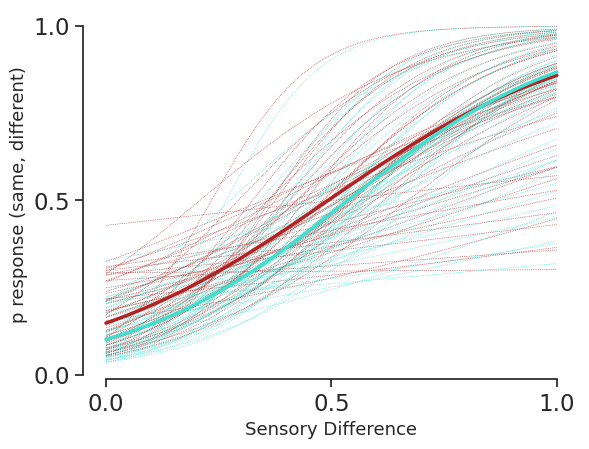

In [48]:
change_vals = np.repeat(np.linspace(0,1,100), 2)
pred_vals = ["0","1"] * 100
response_vals = [""]*200

dat_avg = pd.DataFrame({"id": ["avg"]*200, "change":change_vals, "relevant_expected":pred_vals, "response":response_vals}) # Artificial df to make prediction without rfx
dat_avg["fits"] = relevant_change.predict(dat_avg, use_rfx=False, pred_type='response', skip_data_checks=True, verify_predictions=False, verbose=False)

dat = pd.DataFrame({"id": [],"change":[], "relevant_expected":[], "response":[]})
for id in df["id"].unique(): # Artificial dataframe for each subject
    dat = pd.concat([dat, pd.DataFrame({"id": [id]*200, "change":change_vals, "relevant_expected":pred_vals, "response":response_vals})])
dat["fits"] = relevant_change.predict(dat, use_rfx=True, pred_type='response', skip_data_checks=True, verify_predictions=False, verbose=False) # Predict fits for each subject


ax = plt.subplots()

for id in dat["id"].unique(): # Plotting individual curves
    ax = sns.lineplot(y="fits", x="change", hue = "relevant_expected", linewidth = .5, linestyle = "dotted", palette = ["firebrick", "turquoise"], hue_order = ["0","1"], data = dat[dat.id==id], legend=False) 

# Plotting avg curve
ax = sns.lineplot(y="fits", x="change", hue = "relevant_expected", linewidth = 2.5, palette = ["firebrick", "turquoise"], hue_order = ["0","1"], data = dat_avg, legend=False) 

plt.xlabel("Sensory Difference", fontsize = 13)
plt.ylabel("p response (same, different)", fontsize = 13)
#ax.set(xlabel="Sensory Difference", ylabel="p response (same, different)", fontsize = 15)
ax.set(xticks=[0, 0.5, 1], yticks=[0, .5, 1])
sns.despine(trim=True)
#plt.savefig("figures/exp2/att_curve_raw.png", dpi=500, bbox_inches = "tight")

### Plot estimates

In [49]:
model_estimates = relevant_change.post_hoc(marginal_vars="change", grouping_vars="relevant_expected")[0] # Marginal effects of expectation on change (slopes)

# Intercept estimate and confidence intervals for unexpected trials
unexpected_intercept = {"relevant_expected": 0}
unexpected_intercept["Estimate"] = relevant_change.coefs["Estimate"]["(Intercept)"]
unexpected_intercept["2.5_ci"] = relevant_change.coefs["2.5_ci"]["(Intercept)"]
unexpected_intercept["97.5_ci"] =  relevant_change.coefs["97.5_ci"]["(Intercept)"]
model_estimates = pd.concat([model_estimates, pd.DataFrame(unexpected_intercept, index=[3])])

# Intercept estimate and confidence intervals for expected trials
expected_intercept = {"relevant_expected": 1}
expected_intercept["Estimate"] = relevant_change.coefs["Estimate"]["(Intercept)"] + relevant_change.coefs["Estimate"]["relevant_expected1"] # Intercept value in relation to reference 
expected_intercept["2.5_ci"] = expected_intercept["Estimate"] + relevant_change.coefs["SE"]["relevant_expected1"] * -1.96 # Using SE to find 2.5CI below intercept mean estimate
expected_intercept["97.5_ci"] = expected_intercept["Estimate"] + relevant_change.coefs["SE"]["relevant_expected1"] * 1.96
model_estimates = pd.concat([model_estimates, pd.DataFrame(expected_intercept, index=[4])])

model_estimates["Relevant stimulus"] = ["EXP","UEXP","EXP","UEXP"]
errors = model_estimates['Estimate'] - model_estimates["2.5_ci"]; model_estimates["errors"] = errors

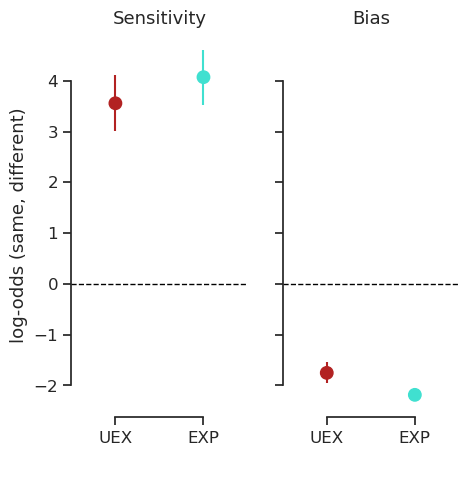

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5), sharey=True)
model_estimates[0:2].plot(x="Relevant stimulus", y='Estimate', kind='bar',
                 ax=ax[0], color = 'none', fontsize=12, 
                 ecolor=["firebrick", "turquoise"],capsize=0,
                 yerr="errors", legend=False)

ax[0].scatter(x=np.arange(model_estimates[0:2].shape[0]),
            marker='o', s=80, 
            y=model_estimates[0:2]['Estimate'],
            color=["firebrick", "turquoise"])


model_estimates[2:4].plot(x="Relevant stimulus", y='Estimate', kind='bar',
                 ax=ax[1], color='none', fontsize=12, 
                 ecolor=["firebrick", "turquoise"],capsize=0,
                 yerr="errors", legend=False)

ax[1].scatter(x=np.arange(model_estimates[2:4].shape[0]),
            marker='o', s=80, 
            y=model_estimates[2:4]['Estimate'],
            color=["firebrick", "turquoise"])

ax[0].set_ylabel("log-odds (same, different)", fontsize=13)
ax[0].set_xlabel(" ")
ax[0].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
ax[0].set_title("Sensitivity", fontsize=13)
ax[1].set_title("Bias", fontsize=13)
ax[1].set_xlabel(" ")
ax[1].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
ax[0].axhline(y=0, linestyle='--', color='black', linewidth=1)
ax[1].axhline(y=0, linestyle='--', color='black', linewidth=1)
sns.despine(ax=ax[0], trim=True)
sns.despine(ax=ax[1], trim=True)

#plt.savefig("figures/exp2/att_estimates_raw.png", dpi=500)

## Irrelevant

In [31]:
irrelevant_change = Lmer("response ~ change * irrelevant_expected + (1 + change|id)", data = df, family="binomial") 
irrelevant_change.fit(factors={**irrelevant_expected, **modality})

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~change*irrelevant_expected+(1+change|id)

Family: binomial	 Inference: parametric

Number of observations: 32421	 Groups: {'id': 57.0}

Log-likelihood: -13877.914 	 AIC: 27769.828

Random effects:

           Name    Var    Std
id  (Intercept)  0.496  0.705
id       change  4.146  2.036

            IV1     IV2  Corr
id  (Intercept)  change -0.79

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.948,-2.154,-1.743,0.105,0.142,0.116,0.175,0.125,0.104,0.149,-18.615,0.000,***
change,3.798,3.249,4.347,0.280,44.607,25.765,77.230,0.978,0.963,0.987,13.561,0.000,***
irrelevant_expected1,-0.176,-0.276,-0.075,0.051,0.839,0.759,0.928,0.456,0.431,0.481,-3.427,0.001,***
change:irrelevant_expected1,0.198,0.041,0.355,0.080,1.219,1.042,1.426,0.549,0.510,0.588,2.472,0.013,*


In [56]:
# # Load models
# irrelevant_change1 = load_model("models/exp2_combined/irrelevantchange1.joblib") # response ~ change * relevant_expected + (1|id)
# irrelevant_change2 = load_model("models/exp2_combined/irrelevantchange2.joblib") # response ~ change * relevant_expected + (1 + change|id)
# irrelevant_change3 = load_model("models/exp2_combined/irrelevantchange3.joblib") # response ~ change * relevant_expected + modality + (1|id)
# irrelevant_change4 = load_model("models/exp2_combined/irrelevantchange4.joblib") # response ~ change * relevant_expected + modality + (1 + change|id)
# irrelevant_change5 = load_model("models/exp2_combined/irrelevantchange5.joblib") # response ~ change * relevant_expected * modality + (1 + change|id)

# # Compare models
# reportAIC([irrelevant_change1, irrelevant_change2, irrelevant_change3, irrelevant_change4, irrelevant_change5])


Model 0: response~change*irrelevant_expected+(1|id)   AIC: 30021.315446396504 ||  BIC: 30063.239610751403
Model 1: response~change*irrelevant_expected+(1+change|id)   AIC: 27695.322692720063 ||  BIC: 27754.01652281692
Model 2: response~change*irrelevant_expected+modality+(1|id)   AIC: 30023.014820954333 ||  BIC: 30073.32381818021
Model 3: response~change*irrelevant_expected+modality+(1+change|id)   AIC: 27683.229100238954 ||  BIC: 27750.30776320679
Model 4: response~change*irrelevant_expected*modality+(1+change|id)   AIC: 27657.951694670737 ||  BIC: 27750.18485625151


### Plot curves

/home/wiseman/miniconda3/envs/pymer4/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


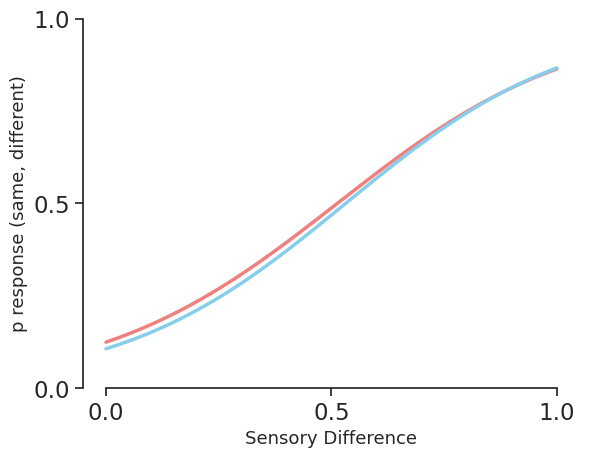

In [53]:
change_vals = np.repeat(np.linspace(0,1,100), 2)
pred_vals = ["0","1"] * 100
response_vals = [""]*200

dat_avg = pd.DataFrame({"id": ["avg"]*200, "change":change_vals, "irrelevant_expected":pred_vals, "response":response_vals}) # Artificial df to make prediction without rfx
dat_avg["fits"] = irrelevant_change.predict(dat_avg, use_rfx=False, pred_type='response', skip_data_checks=True, verify_predictions=False, verbose=False)

dat = pd.DataFrame({"id": [],"change":[], "relevant_expected":[], "response":[]})
for id in df["id"].unique(): # Artificial dataframe for each subject
    dat = pd.concat([dat, pd.DataFrame({"id": [id]*200, "change":change_vals, "irrelevant_expected":pred_vals, "response":response_vals})])
dat["fits"] = irrelevant_change.predict(dat, use_rfx=True, pred_type='response', skip_data_checks=True, verify_predictions=False, verbose=False) # Predict fits for each subject


ax = plt.subplots()

for id in dat["id"].unique(): # Plotting individual curves
    ax = sns.lineplot(y="fits", x="change", hue = "irrelevant_expected", linewidth = .5, linestyle = "dotted", palette = ["lightcoral", "skyblue"], hue_order = ["0","1"], data = dat[dat.id==id], legend=False) 

# Plotting avg curve
ax = sns.lineplot(y="fits", x="change", hue = "irrelevant_expected", linewidth = 2.5, palette = ["lightcoral", "skyblue"], hue_order = ["0","1"], data = dat_avg, legend=False) 

plt.xlabel("Sensory Difference", fontsize = 13)
plt.ylabel("p response (same, different)", fontsize = 13)
#ax.set(xlabel="Sensory Difference", ylabel="p response (same, different)", fontsize = 15)
ax.set(xticks=[0, 0.5, 1], yticks=[0, .5, 1])
sns.despine(trim=True)
#plt.savefig("figures/exp2/ign_curve_raw.png", dpi=500, bbox_inches = "tight")

### Plot estimates

In [54]:
model_estimates = irrelevant_change.post_hoc(marginal_vars="change", grouping_vars="irrelevant_expected")[0] # Marginal effects of expectation on change (slopes)

# Intercept estimate and confidence intervals for unexpected trials
unexpected_intercept = {"irrelevant_expected": 0}
unexpected_intercept["Estimate"] = irrelevant_change.coefs["Estimate"]["(Intercept)"]
unexpected_intercept["2.5_ci"] = irrelevant_change.coefs["2.5_ci"]["(Intercept)"]
unexpected_intercept["97.5_ci"] =  irrelevant_change.coefs["97.5_ci"]["(Intercept)"]
model_estimates = pd.concat([model_estimates, pd.DataFrame(unexpected_intercept, index=[3])])

# Intercept estimate and confidence intervals for expected trials
expected_intercept = {"irrelevant_expected": 1}
expected_intercept["Estimate"] = irrelevant_change.coefs["Estimate"]["(Intercept)"] + irrelevant_change.coefs["Estimate"]["irrelevant_expected1"] # Intercept value in relation to reference 
expected_intercept["2.5_ci"] = expected_intercept["Estimate"] + irrelevant_change.coefs["SE"]["irrelevant_expected1"] * -1.96 # Using SE to find 2.5CI below intercept mean estimate
expected_intercept["97.5_ci"] = expected_intercept["Estimate"] + irrelevant_change.coefs["SE"]["irrelevant_expected1"] * 1.96
model_estimates = pd.concat([model_estimates, pd.DataFrame(expected_intercept, index=[4])])

model_estimates["Irrelevant stimulus"] = ["EXP","UEXP","EXP","UEXP"]
errors = model_estimates['Estimate'] - model_estimates["2.5_ci"]; model_estimates["errors"] = errors

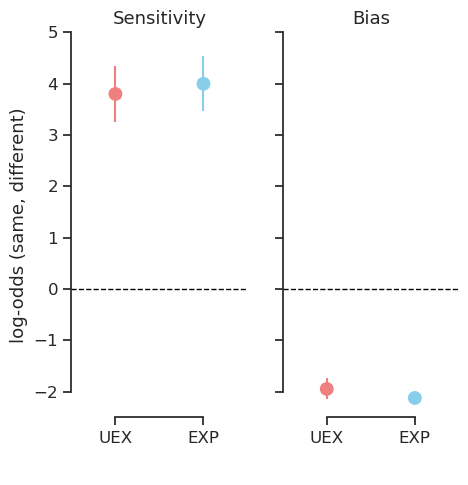

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5), sharey=True)
model_estimates[0:2].plot(x="Irrelevant stimulus", y='Estimate', kind='bar',
                 ax=ax[0], color = 'none', fontsize=12, 
                 ecolor=["lightcoral", "skyblue"],capsize=0,
                 yerr="errors", legend=False)

ax[0].scatter(x=np.arange(model_estimates[0:2].shape[0]),
            marker='o', s=80, 
            y=model_estimates[0:2]['Estimate'],
            color=["lightcoral", "skyblue"])


model_estimates[2:4].plot(x="Irrelevant stimulus", y='Estimate', kind='bar',
                 ax=ax[1], color='none', fontsize=12, 
                 ecolor=["lightcoral", "skyblue"],capsize=0,
                 yerr="errors", legend=False)

ax[1].scatter(x=np.arange(model_estimates[2:4].shape[0]),
            marker='o', s=80, 
            y=model_estimates[2:4]['Estimate'],
            color=["lightcoral", "skyblue"])

ax[0].set_ylabel("log-odds (same, different)", fontsize=13)
ax[0].set_xlabel(" ")
ax[0].set(ylim=[-2.5, 5])
ax[0].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
ax[0].set_title("Sensitivity", fontsize=13)
ax[1].set_title("Bias", fontsize=13)
ax[1].set_xlabel(" ")
ax[1].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
ax[0].axhline(y=0, linestyle='--', color='black', linewidth=1)
ax[1].axhline(y=0, linestyle='--', color='black', linewidth=1)
sns.despine(ax=ax[0], trim=True)
sns.despine(ax=ax[1], trim=True)

#plt.savefig("figures/exp2/ign_estimates_raw.png", dpi=500)

# **Question 3**: Do relevant and irrelevant predictions interact?
The anova on accuracy reveals a significant interaction which can be explained as a difference in irrelevant exp vs uexp only when the relevant modality is expected

## Accuracy

In [64]:
interaction_model = Lmer("correct ~ relevant_expected * irrelevant_expected * modality + (1|id)", data = df, family="binomial") 
interaction_model.fit(factors={**relevant_expected, **irrelevant_expected, **modality})


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: correct~relevant_expected*irrelevant_expected*modality+(1|id)

Family: binomial	 Inference: parametric

Number of observations: 32421	 Groups: {'id': 57.0}

Log-likelihood: -14636.156 	 AIC: 29290.312

Random effects:

           Name    Var    Std
id  (Intercept)  0.149  0.386

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.849,0.664,1.033,0.094,2.337,1.943,2.810,0.700,0.660,0.738,9.010,0.000,***
relevant_expected1,0.167,0.014,0.319,0.078,1.181,1.015,1.375,0.542,0.504,0.579,2.147,0.032,*
irrelevant_expected1,0.024,-0.126,0.175,0.077,1.025,0.882,1.191,0.506,0.469,0.544,0.318,0.750,
modality1,0.774,0.521,1.027,0.129,2.168,1.683,2.793,0.684,0.627,0.736,5.989,0.000,***
relevant_expected1:irrelevant_expected1,0.189,-0.004,0.382,0.098,1.208,0.996,1.466,0.547,0.499,0.594,1.923,0.054,.
relevant_expected1:modality1,0.047,-0.172,0.266,0.112,1.048,0.842,1.304,0.512,0.457,0.566,0.418,0.676,
irrelevant_expected1:modality1,0.041,-0.174,0.256,0.110,1.042,0.840,1.291,0.510,0.457,0.564,0.372,0.710,
relevant_expected1:irrelevant_expected1:modality1,-0.014,-0.292,0.264,0.142,0.986,0.747,1.302,0.497,0.428,0.566,-0.097,0.923,


In [65]:
dat = interaction_model.post_hoc(marginal_vars="irrelevant_expected", grouping_vars="relevant_expected")[0]
errors = dat['Estimate'] - dat["2.5_ci"]; dat["errors"] = errors


In [66]:
interaction_model.post_hoc(marginal_vars="irrelevant_expected", grouping_vars="relevant_expected")


(  irrelevant_expected relevant_expected  Estimate  2.5_ci  97.5_ci     SE   DF
 1                   0                 0     1.236   1.109    1.362  0.065  inf
 2                   1                 0     1.280   1.153    1.408  0.065  inf
 3                   0                 1     1.426   1.296    1.555  0.066  inf
 4                   1                 1     1.653   1.544    1.762  0.056  inf,
                                       Contrast relevant_expected  Estimate  \
 1  irrelevant_expected0 - irrelevant_expected1                 0    -0.045   
 2  irrelevant_expected0 - irrelevant_expected1                 1    -0.227   
 
    2.5_ci  97.5_ci     SE   DF  Z-stat  P-val  Sig  
 1  -0.152    0.063  0.055  inf  -0.815  0.415       
 2  -0.316   -0.139  0.045  inf  -5.032  0.000  ***  )

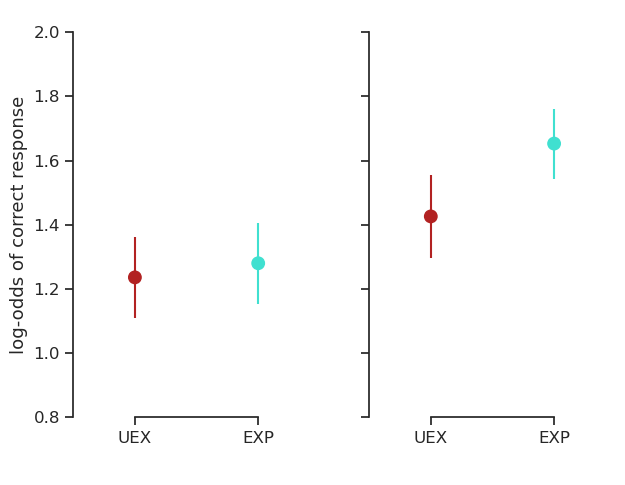

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(7, 5), sharey=True)
dat[0:2].plot(x="relevant_expected", y='Estimate', kind='bar',
                 ax=ax[0], color = 'none', fontsize=12, 
                 ecolor=["firebrick", "turquoise"],capsize=0,
                 yerr="errors", legend=False)

ax[0].scatter(x=np.arange(dat[0:2].shape[0]),
            marker='o', s=80, 
            y=dat[0:2]['Estimate'],
            color=["firebrick", "turquoise"])


dat[2:4].plot(x="relevant_expected", y='Estimate', kind='bar',
                 ax=ax[1], color='none', fontsize=12, 
                 ecolor=["firebrick", "turquoise"],capsize=0,
                 yerr="errors", legend=False)

ax[1].scatter(x=np.arange(dat[2:4].shape[0]),
            marker='o', s=80, 
            y=dat[2:4]['Estimate'],
            color=["firebrick", "turquoise"])

ax[0].set_ylabel("log-odds of correct response", fontsize=13)
ax[0].set_xlabel(" ")
ax[0].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
ax[0].set_title(" ", fontsize=13)
ax[1].set_title(" ", fontsize=13)
ax[1].set_xlabel(" ")
ax[0].set(ylim=[.8, 2])
ax[1].set(ylim=[.8, 2])
ax[1].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
sns.despine(ax=ax[0], trim=True)
sns.despine(ax=ax[1], trim=True)
#plt.savefig("figures/exp2/interaction_estimates.png", dpi=500, bbox_inches='tight')

# Question 4: Is explicit knowledge necessary for the prediction effects to emerge?

## Explicit recall phase

In [70]:
df_explicit = pd.read_csv("data/exp2_explicit.csv")

In [71]:
auditory_group = df[df.modality == "auditory"]["id"].unique()
visual_group = df[df.modality == "visual"]["id"].unique()

### Checking if participants were higher than chance in explicit recall phase

AUDITORY GROUP

In [75]:
exp_auditory = df_explicit[df_explicit.id.isin(auditory_group)]

In [76]:
k = exp_auditory[exp_auditory.modality=="auditory"]["correct"].sum() # Number of correct recalls
n = len(exp_auditory[exp_auditory.modality=="auditory"]) ; # Number of trials
stats.binomtest(k, n, p=0.5, alternative="two-sided") # higher than chance

BinomTestResult(k=123, n=208, alternative='two-sided', statistic=0.5913461538461539, pvalue=0.01013208747531037)

In [77]:
k = exp_auditory[exp_auditory.modality=="visual"]["correct"].sum() # Number of correct recalls
n = len(exp_auditory[exp_auditory.modality=="visual"]) ; # Number of trials
stats.binomtest(k, n, p=0.5, alternative="two-sided")

BinomTestResult(k=100, n=208, alternative='two-sided', statistic=0.4807692307692308, pvalue=0.6275255016466615)

VISUAL GROUP

In [78]:
exp_visual = df_explicit[df_explicit.id.isin(visual_group)]

In [79]:
k = exp_visual[exp_visual.modality=="visual"]["correct"].sum() # Number of correct recalls
n = len(exp_visual[exp_visual.modality=="visual"]) ; # Number of trials
stats.binomtest(k, n, p=0.5, alternative="two-sided") # higher than chance

BinomTestResult(k=130, n=248, alternative='two-sided', statistic=0.5241935483870968, pvalue=0.484940126037265)

In [80]:
k = exp_visual[exp_visual.modality=="auditory"]["correct"].sum() # Number of correct recalls
n = len(exp_visual[exp_visual.modality=="auditory"]) ; # Number of trials
stats.binomtest(k, n, p=0.5, alternative="two-sided") # higher than chance

BinomTestResult(k=133, n=248, alternative='two-sided', statistic=0.5362903225806451, pvalue=0.28033848638430997)

### COMBINED

In [81]:
df_explicit["group"] = np.where(df_explicit["id"].isin(auditory_group), "auditory", "visual")
df_explicit["attended"] = np.where(df_explicit["modality"] == df_explicit["group"], "1", "0")

In [82]:
df_explicit.groupby("attended")["correct"].mean()

attended
0    0.511538
1    0.553846
Name: correct, dtype: float64

In [83]:
k = df_explicit[df_explicit.attended=="0"]["correct"].sum() # Number of correct recalls
n = len(df_explicit[df_explicit.attended=="0"]) ; # Number of trials
stats.binomtest(k, n, p=0.5, alternative="two-sided") # higher than chance

BinomTestResult(k=266, n=520, alternative='two-sided', statistic=0.5115384615384615, pvalue=0.6295769533786575)

In [84]:
k = df_explicit[df_explicit.attended=="1"]["correct"].sum() # Number of correct recalls
n = len(df_explicit[df_explicit.attended=="1"]) ; # Number of trials
stats.binomtest(k, n, p=0.5, alternative="two-sided") # higher than chance

BinomTestResult(k=288, n=520, alternative='two-sided', statistic=0.5538461538461539, pvalue=0.015788055318828355)

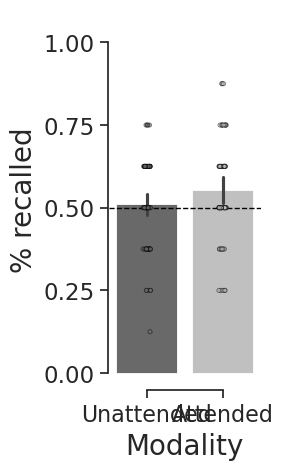

In [85]:
dat = df_explicit.groupby(["id", "attended"], as_index=0)["correct"].mean()
sizeplot = {}; sizeplot["height"] = 5; sizeplot["aspect"] = 0.6
axislabels = {}; axislabels["xlabel"] = 'Modality'; axislabels["ylabel"]= "% recalled"; axislabels["fontsize"]= 20; axislabels["xticks"] = ["Unattended", "Attended"]; axislabels["rotation"] = 0
yaxis = {}; yaxis["yticks"]=[0, .25, .5, .75, 1]; yaxis["ylim"] = [-0.05,1.1]
dx = "attended"; dy = "correct"; hue = "attended";  row = None; col = None
pal = ["dimgray", "silver"]
barsplot(dat, dx, dy, dx, None, None, pal, pal, sizeplot, yaxis, axislabels, sizepoint = 3, dodge = False, lines = False)
plt.axhline(y=.5, linestyle='--', color='black', linewidth=1)
#plt.savefig("figures/exp2/recall_explicit.png", dpi=500, bbox_inches='tight')

### Attended GLMM

In [87]:
att_learned_model = Lmer("correct ~ relevant_expected * att_learned + (1|id)", data = df[df.modality == "auditory"], family="binomial") 
att_learned_model.fit(factors={**relevant_expected, **att_learned})

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: correct~relevant_expected*att_learned+(1|id)

Family: binomial	 Inference: parametric

Number of observations: 13414	 Groups: {'id': 26.0}

Log-likelihood: -7364.109 	 AIC: 14738.218

Random effects:

           Name    Var    Std
id  (Intercept)  0.179  0.423

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.872,0.687,1.057,0.094,2.392,1.988,2.878,0.705,0.665,0.742,9.249,0.000,***
relevant_expected1,0.275,0.181,0.369,0.048,1.316,1.198,1.446,0.568,0.545,0.591,5.719,0.000,***
att_learned1,-0.127,-0.379,0.125,0.129,0.881,0.685,1.133,0.468,0.406,0.531,-0.989,0.322,
relevant_expected1:att_learned1,0.505,0.227,0.783,0.142,1.657,1.254,2.188,0.624,0.556,0.686,3.555,0.000,***


In [88]:
att_learned_model.post_hoc(marginal_vars="relevant_expected", grouping_vars="att_learned")

(  relevant_expected att_learned  Estimate  2.5_ci  97.5_ci     SE   DF
 1                 0           0     0.872   0.687    1.057  0.094  inf
 2                 1           0     1.147   0.973    1.320  0.089  inf
 3                 0           1     0.745   0.459    1.031  0.146  inf
 4                 1           1     1.525   1.286    1.763  0.122  inf,
                                   Contrast att_learned  Estimate  2.5_ci  \
 1  relevant_expected0 - relevant_expected1           0    -0.275  -0.369   
 2  relevant_expected0 - relevant_expected1           1    -0.780  -1.041   
 
    97.5_ci     SE   DF  Z-stat  P-val  Sig  
 1   -0.181  0.048  inf  -5.719    0.0  ***  
 2   -0.518  0.134  inf  -5.833    0.0  ***  )

In [89]:
dat = att_learned_model.post_hoc(marginal_vars="relevant_expected", grouping_vars="att_learned")[0]
errors = dat['Estimate'] - dat["2.5_ci"]; dat["errors"] = errors


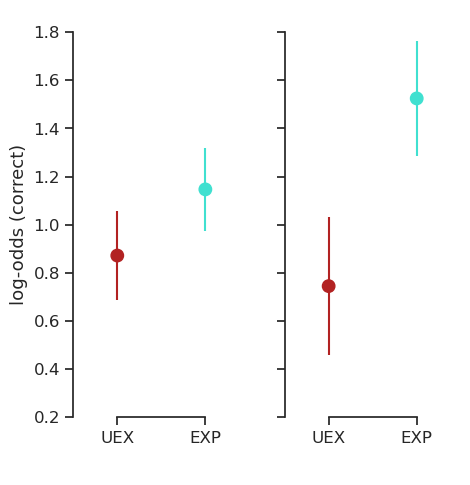

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5), sharey=True)
dat[0:2].plot(x="relevant_expected", y='Estimate', kind='bar',
                 ax=ax[0], color = 'none', fontsize=12, 
                 ecolor=["firebrick", "turquoise"],capsize=0,
                 yerr="errors", legend=False)

ax[0].scatter(x=np.arange(dat[0:2].shape[0]),
            marker='o', s=80, 
            y=dat[0:2]['Estimate'],
            color=["firebrick", "turquoise"])


dat[2:4].plot(x="relevant_expected", y='Estimate', kind='bar',
                 ax=ax[1], color='none', fontsize=12, 
                 ecolor=["firebrick", "turquoise"],capsize=0,
                 yerr="errors", legend=False)

ax[1].scatter(x=np.arange(dat[2:4].shape[0]),
            marker='o', s=80, 
            y=dat[2:4]['Estimate'],
            color=["firebrick", "turquoise"])

ax[0].set_ylabel("log-odds (correct)", fontsize=13)
ax[0].set_xlabel(" ")
ax[0].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
ax[0].set_title(" ", fontsize=13)
ax[1].set_title(" ", fontsize=13)
ax[1].set_xlabel(" ")
ax[0].set(ylim=[0.2, 1.8])
ax[1].set(ylim=[0.2, 1.8])
ax[1].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
sns.despine(ax=ax[0], trim=True)
sns.despine(ax=ax[1], trim=True)
#plt.savefig("figures/exp2/att_recall.png", dpi=500, bbox_inches='tight')

### Unattended GLMM

In [91]:
ign_learned_model = Lmer("correct ~ irrelevant_expected * ign_learned + (1|id)", data = df[df.modality == "auditory"], family="binomial") 
ign_learned_model.fit(factors={**irrelevant_expected, **ign_learned})

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: correct~irrelevant_expected*ign_learned+(1|id)

Family: binomial	 Inference: parametric

Number of observations: 13414	 Groups: {'id': 26.0}

Log-likelihood: -7385.775 	 AIC: 14781.551

Random effects:

           Name    Var    Std
id  (Intercept)  0.173  0.416

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.945,0.764,1.126,0.092,2.573,2.147,3.084,0.720,0.682,0.755,10.235,0.000,***
irrelevant_expected1,0.230,0.139,0.322,0.047,1.259,1.149,1.380,0.557,0.535,0.580,4.934,0.000,***
ign_learned1,-0.281,-0.663,0.100,0.195,0.755,0.515,1.105,0.430,0.340,0.525,-1.446,0.148,
irrelevant_expected1:ign_learned1,0.101,-0.300,0.503,0.205,1.107,0.741,1.654,0.525,0.426,0.623,0.495,0.621,


In [92]:
ign_learned_model.post_hoc(marginal_vars="irrelevant_expected", grouping_vars="ign_learned")

(  irrelevant_expected ign_learned  Estimate  2.5_ci  97.5_ci     SE   DF
 1                   0           0     0.945   0.764    1.126  0.092  inf
 2                   1           0     1.176   1.005    1.346  0.087  inf
 3                   0           1     0.664   0.260    1.067  0.206  inf
 4                   1           1     0.996   0.692    1.300  0.155  inf,
                                       Contrast ign_learned  Estimate  2.5_ci  \
 1  irrelevant_expected0 - irrelevant_expected1           0    -0.230  -0.322   
 2  irrelevant_expected0 - irrelevant_expected1           1    -0.332  -0.723   
 
    97.5_ci     SE   DF  Z-stat  P-val  Sig  
 1   -0.139  0.047  inf  -4.934  0.000  ***  
 2    0.059  0.199  inf  -1.663  0.096    .  )

In [93]:
dat = ign_learned_model.post_hoc(marginal_vars="irrelevant_expected", grouping_vars="ign_learned")[0]
errors = dat['Estimate'] - dat["2.5_ci"]; dat["errors"] = errors

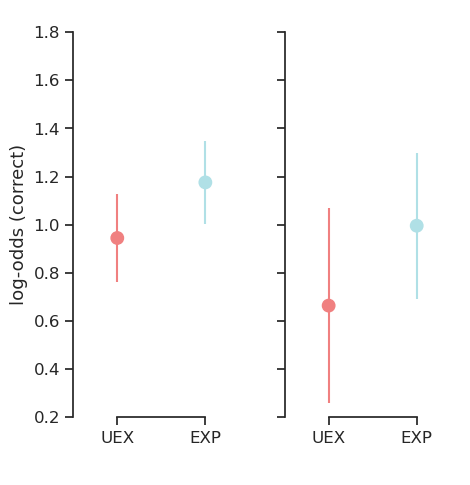

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5), sharey=True)
dat[0:2].plot(x="irrelevant_expected", y='Estimate', kind='bar',
                 ax=ax[0], color = 'none', fontsize=12, 
                 ecolor=["lightcoral", "powderblue"],capsize=0,
                 yerr="errors", legend=False)

ax[0].scatter(x=np.arange(dat[0:2].shape[0]),
            marker='o', s=80, 
            y=dat[0:2]['Estimate'],
            color=["lightcoral", "powderblue"])


dat[2:4].plot(x="irrelevant_expected", y='Estimate', kind='bar',
                 ax=ax[1], color='none', fontsize=12, 
                 ecolor=["lightcoral", "powderblue"],capsize=0,
                 yerr="errors", legend=False)

ax[1].scatter(x=np.arange(dat[2:4].shape[0]),
            marker='o', s=80, 
            y=dat[2:4]['Estimate'],
            color=["lightcoral", "powderblue"])

ax[0].set_ylabel("log-odds (correct)", fontsize=13)
ax[0].set_xlabel(" ")
ax[0].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
ax[0].set_title(" ", fontsize=13)
ax[1].set_title(" ", fontsize=13)
ax[1].set_xlabel(" ")
ax[0].set(ylim=[0.2, 1.8])
ax[1].set(ylim=[0.2, 1.8])
ax[1].set_xticklabels(labels = ["UEX", "EXP"], rotation=0)
sns.despine(ax=ax[0], trim=True)
sns.despine(ax=ax[1], trim=True)
#plt.savefig("figures/exp2/ign_recall.png", dpi=500, bbox_inches='tight')